# XGBoost vs LightGBM

In this notebook we collect the results from all the experiments and reports the comparative difference between XGBoost and LightGBM

In [1]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt
import pandas as pd
import seaborn
%matplotlib inline 

We are going to read the results from the following notebooks

In [2]:
notebooks = {
    'Airline':'01_airline.ipynb',
    'BCI': '02_BCI.ipynb',
    'Football': '03_football.ipynb',
    'Amazon': '04_PlanetKaggle.ipynb',
    'Fraud': '05_FraudDetection.ipynb'
}

In [3]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [4]:
def results_cell_from(nb):
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith('# Results'):
            return cell

In [5]:
def extract_results_from(cell):
    return json.loads(cell['outputs'][0]['text'])

In [6]:
def process_nb(notebook_name):
    return pipe(notebook_name,
                read_notebook,
                results_cell_from,
                extract_results_from)

Here we collect the results from all the exeperiment notebooks. The method simply searches the notebooks for a cell that starts with # Results. It then reads that cells output in as JSON.

In [7]:
results = {nb_key:process_nb(nb_name) for nb_key, nb_name in notebooks.items()}

In [8]:
results

{'Airline': {'lgbm': {'performance': {'AUC': 0.8088160716256416,
    'Accuracy': 0.7354925330901402,
    'F1': 0.694115515892009,
    'Precision': 0.7693890650454324,
    'Recall': 0.632258228111837},
   'test_time': 311.9520166418515,
   'train_time': 638.1008581512142},
  'xgb': {'performance': {'AUC': 0.7868185915163691,
    'Accuracy': 0.7157961369619729,
    'F1': 0.6743572892332877,
    'Precision': 0.7392243023675803,
    'Recall': 0.6199560759698425},
   'test_time': 11.566430455073714,
   'train_time': 4280.392433728091}},
 'Amazon': {'lgbm': {'performance': {'Accuracy': 0.6243840116809637,
    'F1': 0.8962781636444713,
    'Precision': 0.9267527963914166,
    'Recall': 0.8840336262265447},
   'test_time': 7.74908040324226,
   'train_time': 647.7121447487734},
  'xgb': {'performance': {'Accuracy': 0.6252965869684249,
    'F1': 0.8959568265280986,
    'Precision': 0.9265072701831234,
    'Recall': 0.883163855065662},
   'test_time': 1.5602951580658555,
   'train_time': 2186.174

We wish to compare LightGBM and XGBoost both in terms of performance as well as how long they took to train.

In [9]:
def average_performance_diff(dataset):
    lgbm_series = pd.Series(dataset['lgbm']['performance'])
    return 100*((lgbm_series-pd.Series(dataset['xgb']['performance']))/lgbm_series).mean()

In [10]:
def train_time_ratio(dataset):
    return dataset['xgb']['train_time']/dataset['lgbm']['train_time']

def test_time_ratio(dataset):
    return dataset['xgb']['test_time']/dataset['lgbm']['test_time']

In [11]:
metrics = juxt(average_performance_diff, train_time_ratio, test_time_ratio)
res_per_dataset = {dataset_key:metrics(dataset) for dataset_key, dataset in results.items()}

In [12]:
results_df = pd.DataFrame(res_per_dataset, index=['Perf. Difference(%)', 
                                                  'Train Time Ratio', 
                                                  'Test Time Ratio']).T

In [13]:
results_df

,Perf. Difference(%),Train Time Ratio,Test Time Ratio
Airline,2.822119,6.708019,0.037078
Amazon,0.003644,3.375226,0.201352
BCI,4.637308,2.234673,1.569914
Football,0.072358,1.068393,0.003223
Fraud,0.243342,8.207609,2.187446


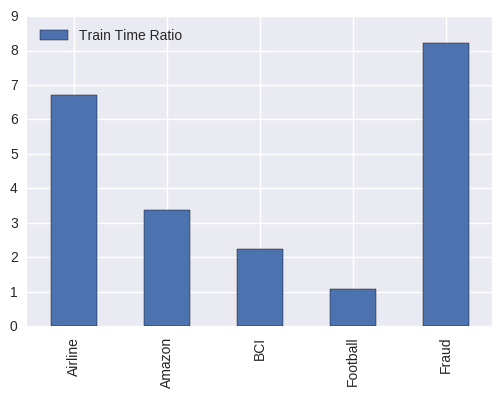

In [14]:
ax = results_df[['Train Time Ratio']].plot(kind='bar');
fig = ax.get_figure()
fig.savefig('train_time_ratio.svg', bbox_inches='tight')

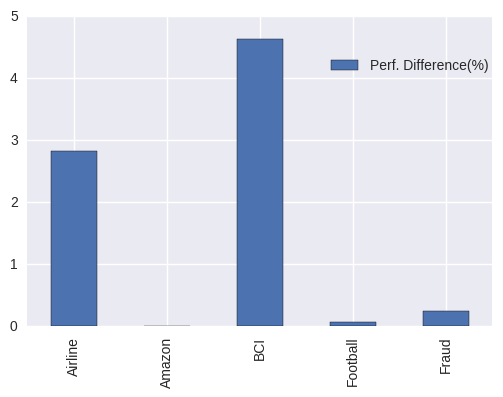

In [15]:
ax = results_df[['Perf. Difference(%)']].plot(kind='bar');
ax.legend(loc=(0.64,0.8))
fig = ax.get_figure()
fig.savefig('perf_diff.svg', bbox_inches='tight')

From the table as well as the plots below we can see that overall the difference in performance is quite small. LightGBM though is 2 to over 10 times quicker than XGBoost.